In [1]:
from os.path import join
import glob
import numpy as np
from scipy.io import loadmat
from scipy.signal import welch, periodogram
from fooof import FOOOF, FOOOFGroup
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from matplotlib import colors, pyplot as plt
from mne.viz import plot_topomap
from mne.stats import permutation_t_test
import nitime.algorithms as tsa
import pickle

In [2]:
data_dir = "../transformer/data/200/"
result_dir = "../results/fooof"

stages = ["AWSL", "NREM", "REM"]
conditions = ["CAF", "PLAC"]

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = loadmat(join("../data", 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [3]:
def get_paths(root, subject="*", stage="*", condition="*"):
    return glob.glob(join(root, f"{subject}n*_{stage}_*_{condition}.npy"))

In [155]:
def power_spectrum(x, num_segments=10, frequency=256):
    #return welch(x, fs=frequency, nperseg=len(x) // num_segments, window='hamming')
    #return periodogram(x, frequency)
    return tsa.multi_taper_psd(x, frequency)[:2]

In [157]:
def process_file(path):
    data = np.load(path)
    freqs = None
    result = []
    for elec in range(20):
        try:
            result[elec]
        except IndexError:
            result.append([])
        for idx in range(len(data)):
            f, p = power_spectrum(data[idx,:,elec])
            result[elec].append(p)
            if freqs is None:
                freqs = f
            assert (freqs == f).all()
    return freqs, np.array(result).mean(axis=1).T
            
freqs = None
powers = {}
for stage in stages:
    powers[stage] = {}
    for condition in conditions:
        result = Parallel(n_jobs=-1)(
            delayed(process_file)(path)
            for path in
            tqdm(get_paths(data_dir, stage=stage, condition=condition)[:8], desc=f"{stage} {condition}")
        )
        f, p = zip(*result)
        powers[stage][condition] = np.stack(p, axis=0).mean(axis=0)
        freqs = f[0]

AWA CAF:   0%|          | 0/8 [00:00<?, ?it/s]

AWA PLAC:   0%|          | 0/8 [00:00<?, ?it/s]

NREM CAF:   0%|          | 0/8 [00:00<?, ?it/s]

NREM PLAC:   0%|          | 0/8 [00:00<?, ?it/s]

REM CAF:   0%|          | 0/8 [00:00<?, ?it/s]

REM PLAC:   0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
#with open(join(result_dir, "fooof-models.pkl"), "rb") as f:
#    models = pickle.load(f)
with open(join(result_dir, "fooof-models-multitaper.pkl"), "rb") as f:
    models = pickle.load(f)

sleep stage:   0%|          | 0/3 [00:00<?, ?it/s]

condition:   0%|          | 0/2 [00:00<?, ?it/s]

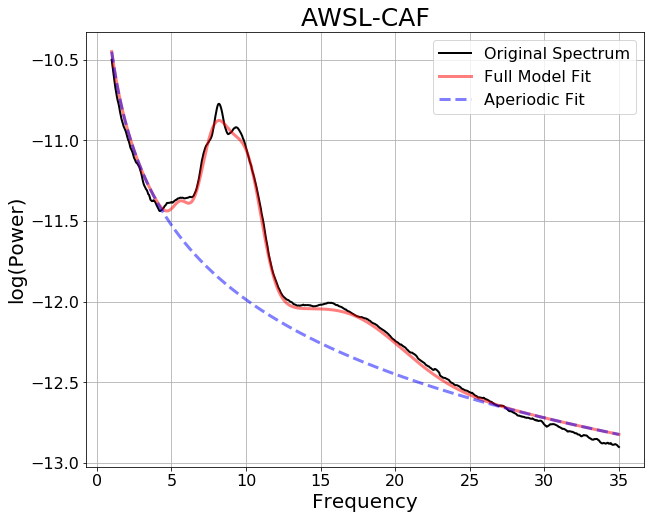

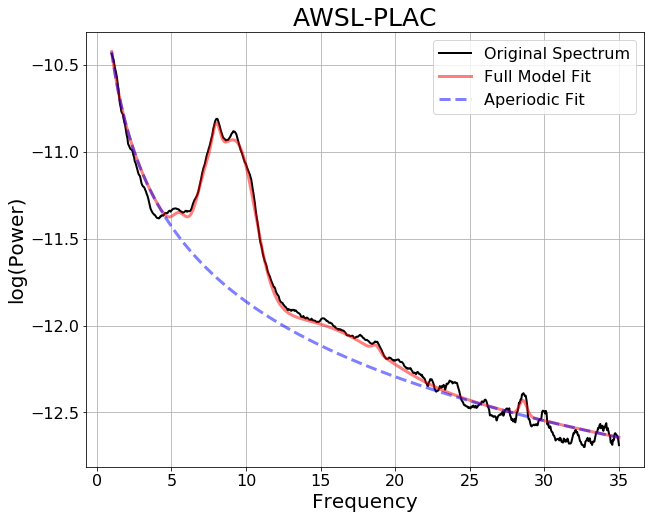

condition:   0%|          | 0/2 [00:00<?, ?it/s]

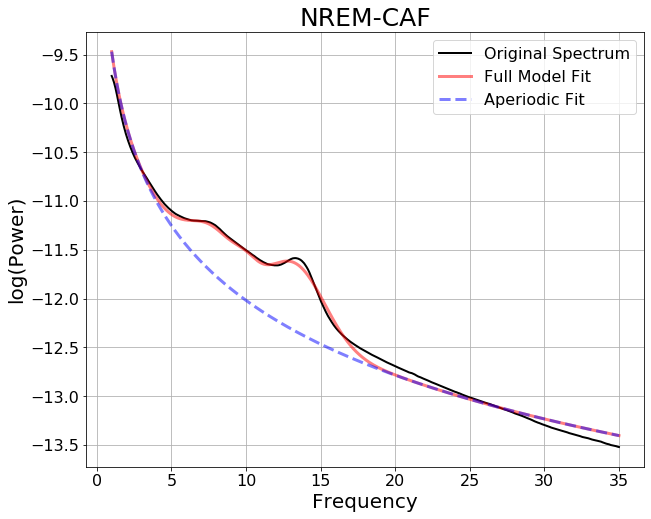

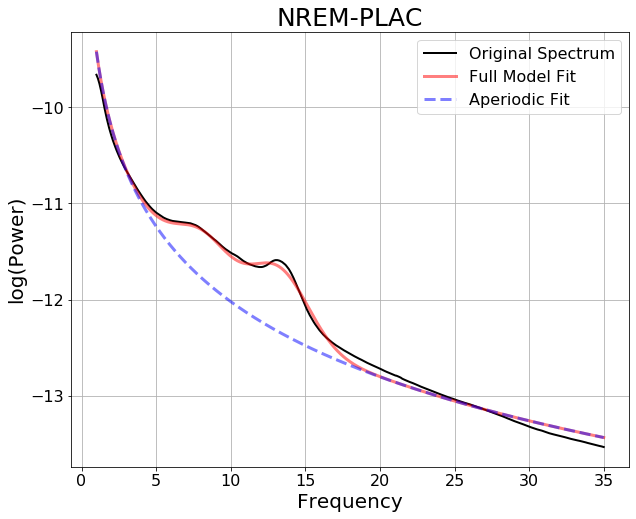

condition:   0%|          | 0/2 [00:00<?, ?it/s]

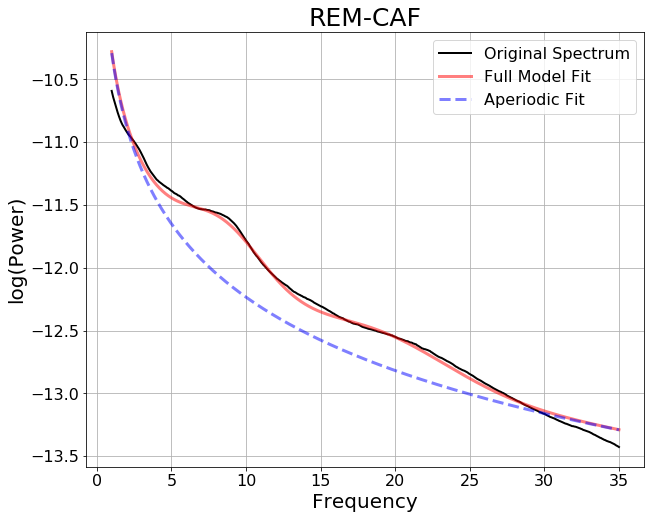

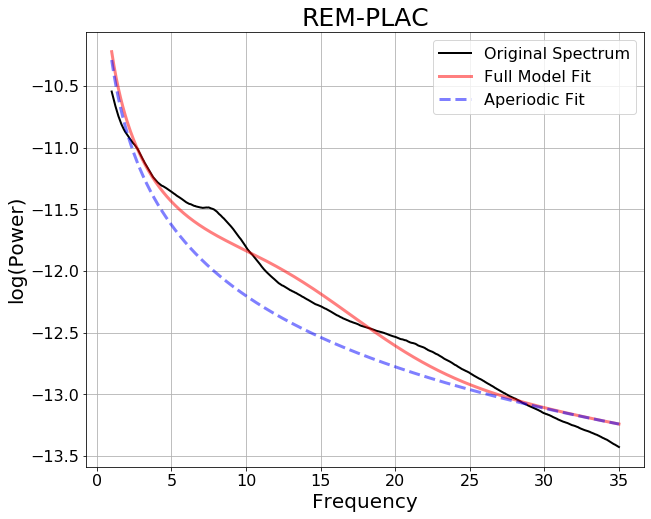

In [10]:
for stage in tqdm(stages, position=0, desc="sleep stage"):
    for condition in tqdm(conditions, position=1, desc="condition", leave=False):
        #fm = FOOOF()
        #fm.fit(freqs, powers[stage][condition].mean(axis=1), [1, 35])
        fm = models[stage][condition]["avg"]
        fm.plot()
        plt.title(f"{stage}-{condition}", fontsize=25)
        plt.show()

In [11]:
oof = {}
for stage in stages:
    oof[stage] = {}
    for condition in conditions:
        oof[stage][condition] = []
        for elec in range(len(models[stage][condition]["chn"])):
            oof[stage][condition].append(models[stage][condition]["chn"][elec].aperiodic_params_[1])

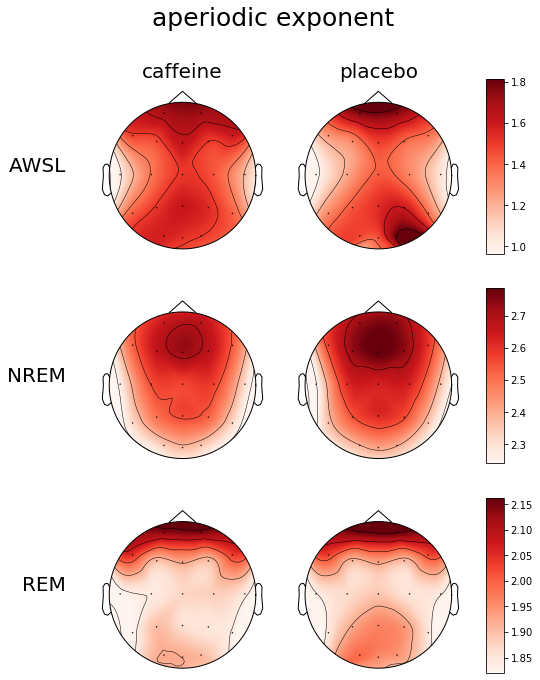

In [12]:
cmap = "Reds"

fig, axes = plt.subplots(len(oof), 4, figsize=(8, 10), gridspec_kw=dict(width_ratios=[0.1, 1, 1, 0.1]))
for stage, ax in zip(oof.keys(), axes):
    ax[0].axis("off")
    ax[0].text(0.5, 0.5, stage, fontsize=20, ha="right", va="center")
    
    vmin = min(min(oof[stage]["CAF"]), min(oof[stage]["PLAC"]))
    vmax = max(max(oof[stage]["CAF"]), max(oof[stage]["PLAC"]))
    plot_topomap(oof[stage]["CAF"], sensor_pos, axes=ax[1], show=False, vmin=vmin, vmax=vmax, cmap=cmap)
    plot_topomap(oof[stage]["PLAC"], sensor_pos, axes=ax[2], show=False, vmin=vmin, vmax=vmax, cmap=cmap)
    
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=ax[3])
axes[0,1].set_title("caffeine", fontsize=20)
axes[0,2].set_title("placebo", fontsize=20)
plt.suptitle("aperiodic exponent", fontsize=25, y=1.05)
plt.show()